Please input directory pathname in format "/name/*" : /Users/T/H2Soutfiles/*


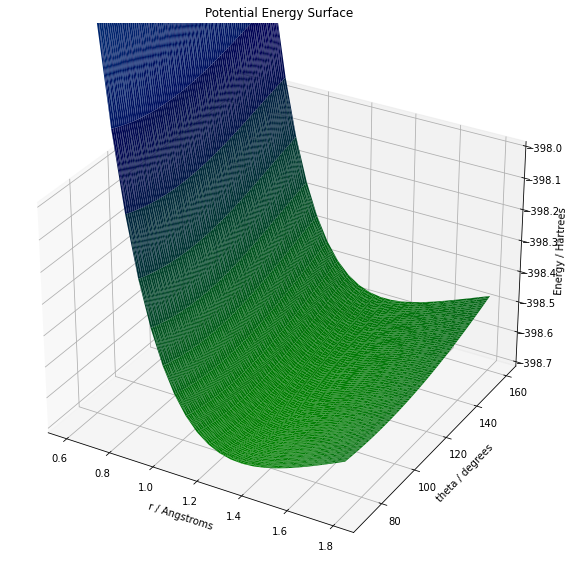

The equilibrium geometry of H2S :
E = -398.67563 Hartree
r = 1.35 Angstroms
theta = 94.0 degrees
v1 vibrational frequency = 3034.84 cm-1
v2 vibrational frequncy = 1281.38 cm-1


In [22]:
import glob
import re
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

def extract():
    '''Extracting data from the directory'''
    pattern_e = re.compile('SCF Done')
    pattern_tr = re.compile('Input=')
    folder_contents = []
    e_list = []
    t_list = []
    r_list = []
    folder_location = input('Please input directory pathname in format "/name/*" :')

    for name in glob.glob(folder_location):
        folder_contents.append(name)
    
    '''Opening each file and reading it line by line to match patterns of relevant data'''
    for file in folder_contents:
        read_file = open(file, 'r+')

        for line in read_file:
            for match in re.finditer(pattern_e, line):
                e_list.append(float(line[22:36]))
            for match in re.finditer(pattern_tr, line):
                molecule_name = str(line[7:10])
                t_list.append(float(line[21:25]))
                r_list.append(float(line[12:16]))
    
    return (e_list, r_list, t_list, molecule_name)

def plot(data):
    '''Plotting the potential energy curve'''
    fig = plt.figure(figsize=(20,10))
    
    ax = fig.gca(projection='3d')
    x = data[1]
    y = data[2]
    z = data[0]
    
    '''Customising z-axis for H2S curve'''
    if data[3] == 'H2S':
        ax.set_zlim(-398.7, -398.0)
    
    ax.plot_trisurf(x, y, z, cmap='ocean')

    ax.set_title('Potential Energy Surface')
    ax.set_xlabel('r / Angstroms')
    ax.set_ylabel('theta / degrees')
    ax.set_zlabel('Energy / Hartrees')

    plt.show()
    
def eqm_geometry(data):
    '''Finding the minimum energy and equilibrium geometry associated with it'''

    min_index = data[0].index(min(data[0], key=float))
    min_e = data[0][min_index]
    min_r = data[1][min_index]
    min_t = data[2][min_index]

    print('The equilibrium geometry of', data[3], ':')
    print('E =', round(min_e,5), 'Hartree')
    print('r =', min_r, 'Angstroms')
    print('theta =', min_t, 'degrees')
    
    return(min_e, min_r, min_t)
    
def vib_freq(data, eqm):
    '''Calculating the vibrational frequencies'''

    mu = 1.66*(10**-27)
    eqm_r = eqm[1]
    eqm_t = eqm[2]
    e_const_r = []
    t_const_r = []
    e_const_t = []
    r_const_t = []
    
    '''Selecting data for 2D analysis at eqm geometry'''    
    for i in range(0, len(data[0])):
        if data[1][i] == eqm_r:
            e_const_r.append(data[0][i])
            t_const_r.append(data[2][i])
        if data[2][i] == eqm_t:
            e_const_t.append(data[0][i])
            r_const_t.append(data[1][i])
            
    r_index = r_const_t.index(eqm_r)
    harmonic_r = []
    harmonic_er = []
    for i in range(r_index - 5, r_index + 5):
        harmonic_r.append(r_const_t[i])
        harmonic_er.append(e_const_t[i])
        
    t_index = t_const_r.index(eqm_t)
    harmonic_t = []
    harmonic_et = []
    for i in range(t_index - 5, t_index + 5):
        harmonic_t.append(t_const_r[i])
        harmonic_et.append(e_const_r[i])
    
    '''Changing the units of r, t and e'''
    e0 = 1.60217653*10**-19
    ep0= 8.8541878*10**-12
    a0 = 0.5291772108*10**-10
    c = 2.99792458*10**8
    
    r_m = (10**-10)*(array(harmonic_r) - eqm_r)
    t_radians = (pi/180)*(array(harmonic_t) - eqm_t)
    e_r_joules = (e0**2/(4*pi*ep0*a0))*array(harmonic_et)
    e_t_joules = (e0**2/(4*pi*ep0*a0))*array(harmonic_er)
    
    '''Using polyfit to find k_r and k_thet then the vibrational frequencies'''
    p1 = polyfit(r_m, e_t_joules, 2)
    p2 = polyfit(t_radians, e_r_joules, 2)
    
    k_r = p1[0]*2
    k_t = p2[0]*2
    
    v1 = (1/(2*pi))*(k_r/(2*mu))**0.5
    v2 = (1/(2*pi))*(k_t/((eqm_r*10**-10)**2*0.5*mu))**0.5
    
    print('v1 vibrational frequency =', round(v1/(c*100),2), 'cm-1')
    print('v2 vibrational frequncy =', round(v2/(c*100),2), 'cm-1')
    
def overall():
    file_data = extract()
    
    plot(file_data)
    
    eqm_data = eqm_geometry(file_data)
    
    vib_freq(file_data, eqm_data)
    
overall()